# Choose sectors, products and diversification paths
This notebook selects target products and sectors for diversification analysis. It focuses on identifying products based on strategic indicators like PCI, density, and proximity—both at the state and firm level.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from adjustText import adjust_text

In [2]:
# Select which data and aggregation to use

data_choice = "labor" # trade / labor
labor_aggregation = "metropolitan_area" # state / metropolitan_area

In [3]:
# Importo tipografía Punto
import os
path = os.path.join(os.path.expanduser('~'), 'Documents/Proyectos/herramientas/')
import matplotlib.font_manager as font_manager
from matplotlib import rcParams
font_dir = [path + 'Raleway/']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)
rcParams['font.family'] = 'Raleway'
font_manager.fontManager

## 1. Read Data

In [4]:
pd.set_option('display.float_format', '{:.2f}'.format) 

In [5]:
# Directory structure and read database

if data_choice == "trade":
    DATASETS_DIR = './datasets_trade/'
    OUTPUTS_DIR = "./outputs_trade/"
    variable = "trade_value"
    code = "HS6"
    location = 'location'
    
elif data_choice == "labor":
    if labor_aggregation == "state":
        DATASETS_DIR = './datasets_labor_states/'
        OUTPUTS_DIR = "./outputs_labor_states/"
        variable = "EMP"
        location = "STATE_NAME"
        code = "NAICS2017"
    
    elif labor_aggregation == "metropolitan_area":
        DATASETS_DIR = './datasets_labor_metropolitan_area/'
        OUTPUTS_DIR = "./outputs_labor_metropolitan_area/"
        variable = "EMP"

In [6]:
relative_density = pd.read_parquet(OUTPUTS_DIR + "relative_density.parquet",engine='fastparquet')

pci = pd.read_parquet(OUTPUTS_DIR + "pci.parquet",engine='fastparquet')

relative_cog = pd.read_parquet(OUTPUTS_DIR + "relative_cog.parquet",engine='fastparquet')

products = pd.read_parquet(OUTPUTS_DIR + "codes.parquet",engine='fastparquet')

locations = pd.read_parquet(OUTPUTS_DIR + "locations.parquet",engine='fastparquet')

rca = pd.read_parquet(OUTPUTS_DIR + "RCA.parquet",engine='fastparquet')

mpa = pd.read_parquet(OUTPUTS_DIR + "Mpa.parquet",engine='fastparquet')

value_level = pd.read_parquet(OUTPUTS_DIR + "value_level.parquet",engine='fastparquet')

eci = pd.read_parquet(OUTPUTS_DIR + "eci.parquet",engine='fastparquet')

proximity = pd.read_parquet(OUTPUTS_DIR + "proximity.parquet",engine='fastparquet')

In [7]:
naics_equivalence = pd.read_excel(DATASETS_DIR + "NAICS_EQUIVALENCE.xlsx")
naics_equivalence.dtypes

naics_code              object
naics_description       object
level                    int64
parent_code             object
automotive_subsector    object
supply_chain_stage      object
sector_alignment        object
strategic_sector        object
dtype: object

In [8]:
sectors = pd.read_excel(DATASETS_DIR + "Sector classification NAICS 11.25.xlsx", sheet_name='NAICS')
sectors.rename(columns={"2022 NAICS Codes": "NAICS_6"}, inplace=True)
sectors['NAICS_6'] = sectors["NAICS_6"].apply(lambda x: f'{x:06}')
sectors = sectors.loc[sectors["Relevance"] == "Core"]
sectors_6digits = sectors[['NAICS_6', 'Strategic Sector']].drop_duplicates(subset=["NAICS_6", "Strategic Sector"], keep="first")
#sectors_6digits["NAICS_5"] = sectors_6digits["NAICS_6"].str[:5]
sectors_6digits.head()

,NAICS_6,Strategic Sector
0,336411,Aerospace
1,336412,Aerospace
2,336413,Aerospace
3,336414,Aerospace
4,336415,Aerospace


In [9]:
concordance_2017_2022 = pd.read_excel(DATASETS_DIR + "2017_to_2022_NAICS.xlsx")
concordance_2017_2022.rename(columns={"2017 NAICS Code": "code", "2022 NAICS Code" :"NAICS_2022", "2022 NAICS Title": "NAICS_Description"}, inplace=True)
concordance_2017_2022["code"] = concordance_2017_2022["code"].astype(str)
concordance_2017_2022["NAICS_2022"] = concordance_2017_2022["NAICS_2022"].astype(str)
#concordance_2017_2022["code_5"] = concordance_2017_2022["code"].str[:5]
#concordance_2017_2022["NAICS_2022_5"] = concordance_2017_2022["NAICS_2022"].str[:5]
concordance_2017_2022.head()

,code,2017 NAICS Title\n(and specific piece of the 2017 industry that is contained in the 2022 industry),NAICS_2022,NAICS_Description
0,111110,Soybean Farming,111110,Soybean Farming
1,111120,Oilseed (except Soybean) Farming,111120,Oilseed (except Soybean) Farming
2,111130,Dry Pea and Bean Farming,111130,Dry Pea and Bean Farming
3,111140,Wheat Farming,111140,Wheat Farming
4,111150,Corn Farming,111150,Corn Farming


In [10]:
msa_codes = pd.read_excel(DATASETS_DIR + "list2_2023.xlsx")
msa_codes = msa_codes[["CBSA Code", "CBSA Title"]]
msa_codes.rename(columns={"CBSA Code": "cbsa"}, inplace=True)
msa_codes.drop_duplicates(subset=["cbsa"], keep="first", inplace=True)

In [11]:
codes = products.iloc[:, 0].astype(str) 

rel_cog_long = (relative_cog.stack().rename("relative_cog").to_frame())
rel_density_long = relative_density.stack().rename("density").to_frame()
rca_long         = rca.stack().rename("rca").to_frame()
mpa_long         = mpa.stack().rename("mcp").to_frame()
value_long       = value_level.stack().rename(variable).to_frame()

df_long = (rel_cog_long.join(rel_density_long).join(rca_long).join(mpa_long).join(value_long).reset_index())
df_long = df_long.rename(columns={df_long.columns[0]: "location", df_long.columns[1]: "code"})

df_pci = pd.DataFrame({"code": codes.values})
df_pci["pci"] = (pci.values)

df_full = df_long.merge(df_pci, on="code", how="left")
df_full = df_full.merge(msa_codes, how="left", left_on='location', right_on ="cbsa").drop(columns=['cbsa'])
df_full = df_full.merge(concordance_2017_2022[["code", "NAICS_2022"]], how="left", on="code")
df_full = df_full.merge(sectors_6digits[["NAICS_6", "Strategic Sector"]], left_on="NAICS_2022", right_on="NAICS_6", how="left")
df_full = df_full.drop(columns=["NAICS_6", "code"])
df_full = df_full.groupby(["location","CBSA Title","NAICS_2022", "Strategic Sector"], dropna=False).mean().reset_index()
df_full.head()

,location,CBSA Title,NAICS_2022,Strategic Sector,relative_cog,density,rca,mcp,EMP,pci
0,10100,"Aberdeen, SD",113110,NaN,-0.94,-0.20,0.00,0.00,0.00,-0.59
1,10100,"Aberdeen, SD",113210,NaN,-0.87,-0.76,0.00,0.00,0.00,0.37
2,10100,"Aberdeen, SD",113310,NaN,-1.65,2.55,0.00,0.00,0.00,-1.65
3,10100,"Aberdeen, SD",114111,NaN,-1.29,0.23,0.00,0.00,0.00,-0.90
4,10100,"Aberdeen, SD",114112,NaN,-1.04,-0.15,0.00,0.00,0.00,-0.69


In [12]:
pci_summary = df_full.loc[(df_full.mcp == 1)].groupby("CBSA Title").agg(
    avg_pci=("pci", "mean"),
    median_pci=("pci", "median"),
    product_count=("NAICS_2022", "count"),
    high_complex_products=("pci", lambda x: (x > 1).sum()),
    low_complex_products=("pci", lambda x: (x < -1).sum())
).reset_index()

pci_summary.sort_values(by="avg_pci", ascending=False)

,CBSA Title,avg_pci,median_pci,product_count,high_complex_products,low_complex_products
160,"Chicago-Naperville-Elgin, IL-IN",0.30,0.32,383,107,36
490,"Los Angeles-Long Beach-Anaheim, CA",0.28,0.37,420,109,47
102,"Boston-Cambridge-Newton, MA-NH",0.20,0.21,264,60,30
169,"Cleveland, OH",0.17,0.14,281,63,32
597,"New York-Newark-Jersey City, NY-NJ",0.16,0.14,303,66,39
...,...,...,...,...,...,...
862,"Vernon, TX",-1.63,-1.67,23,0,22
692,"Raymondville, TX",-1.63,-1.71,12,0,11
816,"Summerville, GA",-1.63,-1.67,21,0,21
860,"Vermillion, SD",-1.65,-1.67,25,0,25


In [13]:
df_full["naics_level2"] = df_full["NAICS_2022"].str[:2]
df_full = df_full.merge(naics_equivalence[["naics_code", "naics_description"]], left_on="naics_level2", right_on="naics_code", how="left")

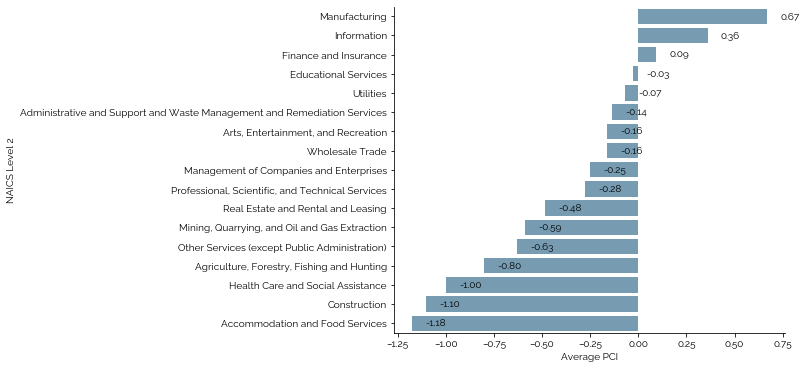

In [14]:
df_unique_products = df_full.drop_duplicates(subset=["NAICS_2022"])
pci_by_section = df_unique_products.groupby("naics_description")["pci"].mean().reset_index()
pci_by_section = pci_by_section.sort_values(by="pci", ascending=False).reset_index()

fig = plt.figure(figsize=(7, 6))
sns.barplot(data=pci_by_section, x="pci", y="naics_description", color="#6d9ebc")
plt.xlabel("Average PCI")
plt.ylabel("NAICS Level 2")
for index, row in pci_by_section.iterrows():
    plt.text(row["pci"] + 0.07, index, f"{row['pci']:.2f}", va='center')
sns.despine()
#fig.savefig("figs/pci_section.png", dpi=600, bbox_inches='tight', transparent=True)
plt.show()

In [28]:
df_full.drop(columns=['naics_level2', ], inplace=True)
df_full.rename(columns={"naics_description": "naics_level2_desc"}, inplace=True)
df_full = df_full.merge(naics_equivalence[["naics_code", "naics_description"]], left_on="NAICS_2022", right_on="naics_code", how="left")
df_full.head()

,location,CBSA Title,NAICS_2022,Strategic Sector,relative_cog,density,rca,mcp,EMP,pci,naics_code_x,naics_level2_desc,presence,naics_code_y,naics_description
0,10100,"Aberdeen, SD",113110,NaN,-0.94,-0.20,0.00,0.00,0.00,-0.59,11,"Agriculture, Forestry, Fishing and Hunting",0,113110,Timber Tract Operations
1,10100,"Aberdeen, SD",113210,NaN,-0.87,-0.76,0.00,0.00,0.00,0.37,11,"Agriculture, Forestry, Fishing and Hunting",0,113210,Forest Nurseries and Gathering of Forest Products
2,10100,"Aberdeen, SD",113310,NaN,-1.65,2.55,0.00,0.00,0.00,-1.65,11,"Agriculture, Forestry, Fishing and Hunting",0,113310,Logging
3,10100,"Aberdeen, SD",114111,NaN,-1.29,0.23,0.00,0.00,0.00,-0.90,11,"Agriculture, Forestry, Fishing and Hunting",0,114111,Finfish Fishing
4,10100,"Aberdeen, SD",114112,NaN,-1.04,-0.15,0.00,0.00,0.00,-0.69,11,"Agriculture, Forestry, Fishing and Hunting",0,114112,Shellfish Fishing


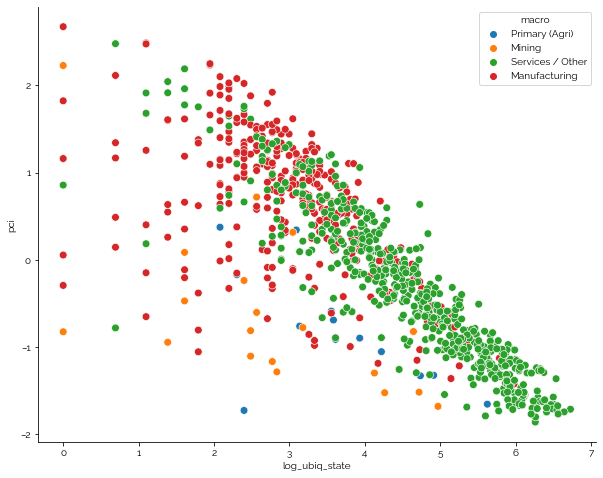

In [15]:
df_full["presence"] = (df_full["rca"] >= 1).astype(int)

ubiq = df_full.loc[df_full["presence"] == 1].groupby("NAICS_2022")["location"].nunique().rename("ubiq_state").reset_index()

pci_all = (df_full[["NAICS_2022", "pci"]].drop_duplicates().merge(ubiq, on="NAICS_2022", how="left"))
pci_all["log_ubiq_state"] = np.log(pci_all["ubiq_state"])

def macro_sector(naics4):
    n2 = int(str(naics4)[:2])
    if 31 <= n2 <= 33:
        return "Manufacturing"
    elif n2 == 11:
        return "Primary (Agri)"
    elif n2 == 21:
        return "Mining"
    else:
        return "Services / Other"

pci_all["macro"] = pci_all["NAICS_2022"].apply(macro_sector)

plt.figure(figsize=(10,8))
sns.scatterplot(data=pci_all, x="log_ubiq_state", y="pci", hue="macro", s=60)
sns.despine()
plt.show()

In [16]:
top_332992 = (df_full.loc[df_full["NAICS_2022"] == "332992"].sort_values(["rca", "density"], ascending=False))
top_332992[['CBSA Title', 'density', 'rca', 'EMP']].head(15)

,CBSA Title,density,rca,EMP
300539,"Grand Island, NE",-0.10,1792.53,1077.00
74894,"Bend, OR",0.16,109.58,213.00
636704,"Rapid City, SD",-0.01,61.52,78.00
671702,"St. George, UT",0.06,55.17,79.00
737093,"Springfield, MO",0.20,44.13,195.00
673544,"St. Louis, MO-IL",2.35,28.11,808.00
90551,"Boise City, ID",0.50,3.79,27.00
603548,"Phoenix-Mesa-Chandler, AZ",2.78,1.93,91.00
190019,"Dallas-Fort Worth-Arlington, TX",6.00,1.76,143.00
424874,"Las Vegas-Henderson-North Las Vegas, NV",-0.42,0.92,20.00


In [17]:
top_332993 = (df_full.loc[df_full["NAICS_2022"] == "332993"].sort_values(["rca", "density"], ascending=False))
top_332993[['CBSA Title', 'density', 'rca', 'pci', 'EMP']].head(15)

,CBSA Title,density,rca,pci,EMP
603549,"Phoenix-Mesa-Chandler, AZ",6.22,46.66,1.34,251.00
812616,"Washington-Arlington-Alexandria, DC-VA-MD-WV",9.12,8.80,1.34,66.00
687360,"San Jose-Sunnyvale-Santa Clara, CA",1.97,0.00,1.34,0.00
552894,"New York-Newark-Jersey City, NY-NJ",0.53,0.00,1.34,0.00
94236,"Boston-Cambridge-Newton, MA-NH",0.53,0.00,1.34,0.00
451584,"Los Angeles-Long Beach-Anaheim, CA",0.27,0.00,1.34,0.00
190020,"Dallas-Fort Worth-Arlington, TX",0.05,0.00,1.34,0.00
700254,"Seattle-Tacoma-Bellevue, WA",-0.11,0.00,1.34,0.00
51870,"Austin-Round Rock-San Marcos, TX",-0.25,0.00,1.34,0.00
147654,"Chicago-Naperville-Elgin, IL-IN",-0.28,0.00,1.34,0.00


Looks like you are using an old matplotlib version.
               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


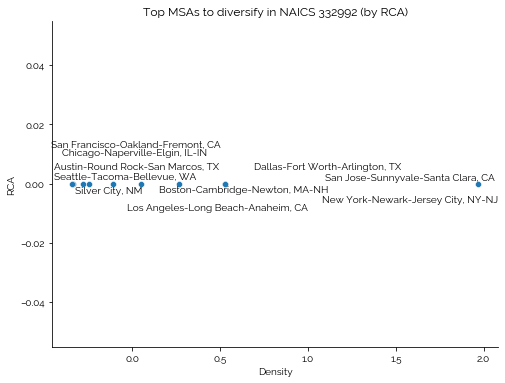

In [18]:
top_332993 = (df_full.loc[df_full["NAICS_2022"] == "332993"].sort_values(["rca", "density"], ascending=False))
plt.figure(figsize=(8,6))
ax = sns.scatterplot(data=top_332993.loc[top_332993.rca < 1].head(10), x="density", y="rca")
label_col = "CBSA Title" if "CBSA Title" in top_332993.loc[top_332993.rca < 1].head(10).columns else "cbsa"
texts = []
for _, row in top_332993.loc[top_332993.rca < 1].head(10).iterrows():
    texts.append(ax.text(row["density"], row["rca"], str(row[label_col]), fontsize=10))
adjust_text(texts, ax=ax)
ax.set_xlabel("Density")
ax.set_ylabel("RCA")
ax.set_title("Top MSAs to diversify in NAICS 332992 (by RCA)")
sns.despine()
plt.show()

Looks like you are using an old matplotlib version.
               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


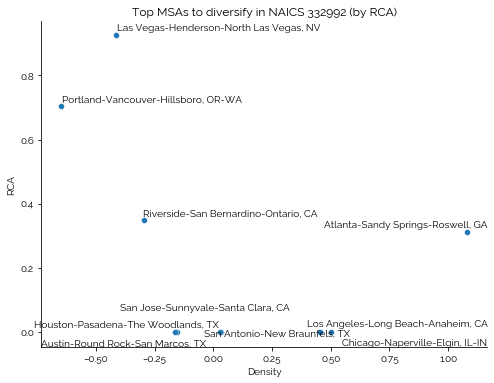

In [19]:
top_332992 = (df_full.loc[df_full["NAICS_2022"] == "332992"].sort_values(["rca", "density"], ascending=False))
plt.figure(figsize=(8,6))
ax = sns.scatterplot(data=top_332992.loc[top_332992.rca < 1].head(10), x="density", y="rca")
label_col = "CBSA Title" if "CBSA Title" in top_332992.loc[top_332992.rca < 1].head(10).columns else "cbsa"
texts = []
for _, row in top_332992.loc[top_332992.rca < 1].head(10).iterrows():
    texts.append(ax.text(row["density"], row["rca"], str(row[label_col]), fontsize=10))
adjust_text(texts, ax=ax)
ax.set_xlabel("Density")
ax.set_ylabel("RCA")
ax.set_title("Top MSAs to diversify in NAICS 332992 (by RCA)")
sns.despine()
plt.show()

Looks like you are using an old matplotlib version.
               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


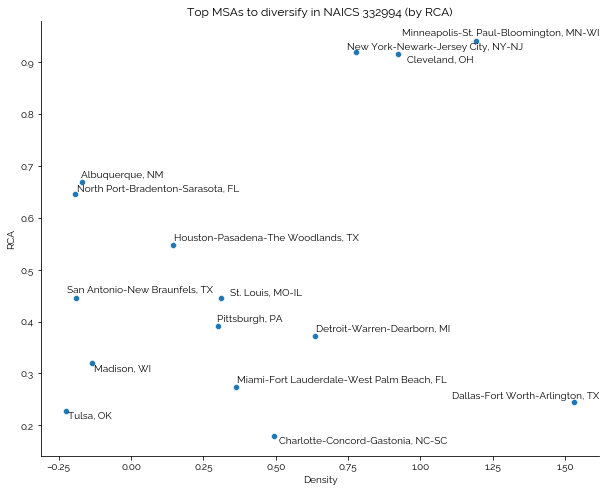

In [20]:
top_332994 = (df_full.loc[df_full["NAICS_2022"] == "332994"].sort_values(["rca", "density"], ascending=False))
plt.figure(figsize=(10,8))
ax = sns.scatterplot(data=top_332994.loc[top_332994.rca < 1].head(15), x="density", y="rca")
label_col = "CBSA Title" if "CBSA Title" in top_332994.loc[top_332994.rca < 1].head(15).columns else "cbsa"
texts = []
for _, row in top_332994.loc[top_332994.rca < 1].head(15).iterrows():
    texts.append(ax.text(row["density"], row["rca"], str(row[label_col]), fontsize=10))
adjust_text(texts, ax=ax)
ax.set_xlabel("Density")
ax.set_ylabel("RCA")
ax.set_title("Top MSAs to diversify in NAICS 332994 (by RCA)")
sns.despine()
plt.show()

In [21]:
top_336992 = (df_full.loc[df_full["NAICS_2022"] == "336992"].sort_values(["rca", "density"], ascending=False))
top_336992[['CBSA Title', 'density', 'rca', 'pci', 'EMP']].head(15)

,CBSA Title,density,rca,pci,EMP
31710,"Anniston-Oxford, AL",0.72,1885.96,0.14,632.00
207621,"Detroit-Warren-Dearborn, MI",19.62,39.29,0.14,931.00
147756,"Chicago-Naperville-Elgin, IL-IN",2.10,0.00,0.14,0.00
156045,"Cleveland, OH",1.28,0.00,0.14,0.00
451686,"Los Angeles-Long Beach-Anaheim, CA",0.56,0.00,0.14,0.00
610098,"Pittsburgh, PA",-0.36,0.00,0.14,0.00
278538,"Franklin, KY",-0.48,0.00,0.14,0.00
802587,"Wabash, IN",-0.54,0.00,0.14,0.00
806271,"Wapakoneta, OH",-0.55,0.00,0.14,0.00
366033,"Jackson, MI",-0.56,0.00,0.14,0.00


Looks like you are using an old matplotlib version.
               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


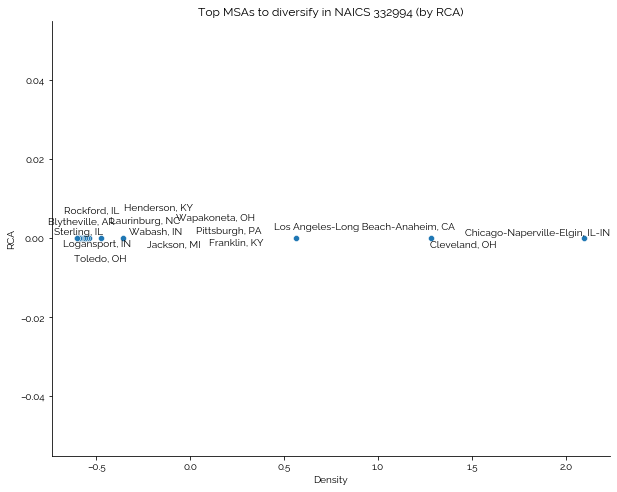

In [22]:
plt.figure(figsize=(10,8))
ax = sns.scatterplot(data=top_336992.loc[top_336992.rca < 1].head(15), x="density", y="rca")
label_col = "CBSA Title" if "CBSA Title" in top_336992.loc[top_336992.rca < 1].head(15).columns else "cbsa"
texts = []
for _, row in top_336992.loc[top_336992.rca < 1].head(15).iterrows():
    texts.append(ax.text(row["density"], row["rca"], str(row[label_col]), fontsize=10))
adjust_text(texts, ax=ax)
ax.set_xlabel("Density")
ax.set_ylabel("RCA")
ax.set_title("Top MSAs to diversify in NAICS 332994 (by RCA)")
sns.despine()
plt.show()

In [29]:
df_sector = df_full.loc[df_full["Strategic Sector"].isin(['Defense', 'Aerospace', 'Life Sciences', 'Shipbuilding'])]

Looks like you are using an old matplotlib version.
               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


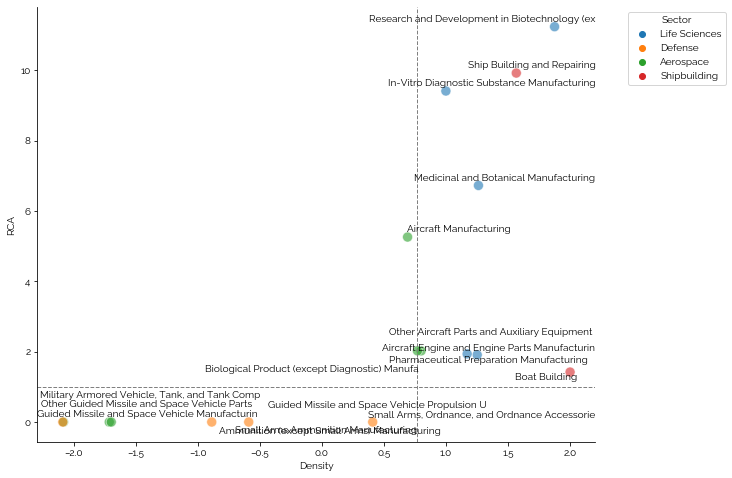

In [34]:
states_sel = ["41740"]
df_plot = df_sector[df_sector["location"].isin(states_sel)].copy()

fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=df_plot, x="density", y="rca",hue="Strategic Sector", alpha=0.6, s=100)
plt.axhline(1, ls="--", lw=1, color="grey")  # RCA = 1 threshold
plt.axvline(df_plot["density"].median(), ls="--", lw=1, color="grey")  # median density (only for selected states)
texts = []
for _, row in df_plot.iterrows():
    texts.append(ax.text(row["density"], row["rca"], str(row['naics_description'][0:45]), fontsize=10))
adjust_text(texts, ax=ax)
plt.xlabel("Density")
plt.ylabel("RCA")
plt.legend(title="Sector", bbox_to_anchor=(1.05, 1), loc="upper left")
sns.despine()
plt.show()

In [43]:
sd_row

NAICS_2022      336612
density           2.00
density_rank        54
Name: 53, dtype: object

In [45]:
df_full.loc[df_full["Strategic Sector"].isin(['Defense', 'Aerospace', 'Life Sciences', 'Shipbuilding'])].drop_duplicates(subset=["NAICS_2022"]).shape

(17, 15)

In [53]:
tmp

,location,CBSA Title,NAICS_2022,Strategic Sector,relative_cog,density,rca,mcp,EMP,pci,naics_code_x,naics_level2_desc,presence,naics_code_y,naics_description,density_rank,rca_rank
0,37100,"Oxnard-Thousand Oaks-Ventura, CA",541714,Life Sciences,-0.59,0.44,16.83,1.00,5571.00,0.41,54,"Professional, Scientific, and Technical Services",1,541714,Research and Development in Biotechnology (exc...,26,1
1,41740,"San Diego-Chula Vista-Carlsbad, CA",541714,Life Sciences,-1.51,1.88,11.24,1.00,19093.00,0.41,54,"Professional, Scientific, and Technical Services",1,541714,Research and Development in Biotechnology (exc...,8,2
2,20500,"Durham-Chapel Hill, NC",541714,Life Sciences,-0.38,1.56,10.77,1.00,3839.00,0.41,54,"Professional, Scientific, and Technical Services",1,541714,Research and Development in Biotechnology (exc...,9,3
3,35300,"New Haven, CT",541714,Life Sciences,-0.21,0.23,8.02,1.00,2537.00,0.41,54,"Professional, Scientific, and Technical Services",1,541714,Research and Development in Biotechnology (exc...,35,4
4,14460,"Boston-Cambridge-Newton, MA-NH",541714,Life Sciences,-2.37,3.93,7.92,1.00,26121.00,0.41,54,"Professional, Scientific, and Technical Services",1,541714,Research and Development in Biotechnology (exc...,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
920,41140,"St. Joseph, MO-KS",541714,Life Sciences,0.05,-0.52,0.00,0.00,0.00,0.41,54,"Professional, Scientific, and Technical Services",0,541714,Research and Development in Biotechnology (exc...,401,921
921,19500,"Decatur, IL",541714,Life Sciences,0.06,-0.52,0.00,0.00,0.00,0.41,54,"Professional, Scientific, and Technical Services",0,541714,Research and Development in Biotechnology (exc...,402,922
922,12860,"Batavia, NY",541714,Life Sciences,0.05,-0.52,0.00,0.00,0.00,0.41,54,"Professional, Scientific, and Technical Services",0,541714,Research and Development in Biotechnology (exc...,403,923
923,44340,"Statesboro, GA",541714,Life Sciences,0.04,-0.52,0.00,0.00,0.00,0.41,54,"Professional, Scientific, and Technical Services",0,541714,Research and Development in Biotechnology (exc...,404,924


In [59]:
naics_list = df_full.loc[df_full["Strategic Sector"].isin(['Defense', 'Aerospace', 'Life Sciences', 'Shipbuilding'])]["NAICS_2022"].drop_duplicates().tolist()
metro = "41740"

rows = []

for code in naics_list:
    tmp = df_full[df_full["NAICS_2022"] == code].copy()
    tmp = tmp.sort_values("density", ascending=False).reset_index(drop=True)
    tmp["density_rank"] = tmp.index + 1
    tmp = tmp.sort_values("rca", ascending=False).reset_index(drop=True)
    tmp["rca_rank"] = tmp.index + 1
    sd_row = tmp.loc[tmp["location"] == metro, ["NAICS_2022", "naics_description",'Strategic Sector', "density", "density_rank", "rca", "rca_rank"]]
    if sd_row.empty:
        rows.append({"NAICS_2022": code, "density": None,"density_rank": None,"N_MSAs": len(tmp), "density_percentile": None})
    else:
        sd_row = sd_row.iloc[0]
        N = len(tmp)
        pct = 100 * (1 - (sd_row["density_rank"] - 1) / N)
        rows.append({"NAICS_2022": code, "NAICS_Description": sd_row["naics_description"],'Strategic Sector' : sd_row["Strategic Sector"],"density": sd_row["density"],
                     "density_rank": int(sd_row["density_rank"]),"N_MSAs": N,"density_percentile": pct,"rca": sd_row["rca"],
                     "rca_rank": int(sd_row["rca_rank"])})

sd_ranks = pd.DataFrame(rows)
sd_ranks.sort_values(by=["Strategic Sector"])

,NAICS_2022,NAICS_Description,Strategic Sector,density,density_rank,N_MSAs,density_percentile,rca,rca_rank
8,336412,Aircraft Engine and Engine Parts Manufacturing,Aerospace,0.80,13,925,98.70,2.02,16
12,336419,Other Guided Missile and Space Vehicle Parts a...,Aerospace,-2.08,890,925,3.89,0.00,341
11,336415,Guided Missile and Space Vehicle Propulsion Un...,Aerospace,-1.70,867,925,6.38,0.00,291
10,336414,Guided Missile and Space Vehicle Manufacturing,Aerospace,-1.71,874,925,5.62,0.00,327
7,336411,Aircraft Manufacturing,Aerospace,0.69,11,925,98.92,5.26,9
9,336413,Other Aircraft Parts and Auxiliary Equipment M...,Aerospace,0.77,17,925,98.27,2.02,20
4,332992,Small Arms Ammunition Manufacturing,Defense,-0.59,449,925,51.57,0.00,766
5,332993,Ammunition (except Small Arms) Manufacturing,Defense,-0.89,493,925,46.81,0.00,146
6,332994,"Small Arms, Ordnance, and Ordnance Accessories...",Defense,0.41,25,925,97.41,0.00,633
15,336992,"Military Armored Vehicle, Tank, and Tank Compo...",Defense,-2.09,911,925,1.62,0.00,305


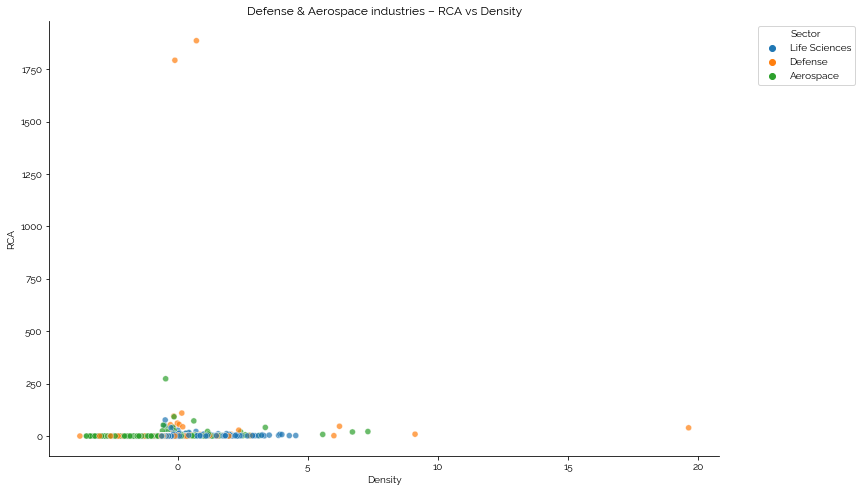

In [76]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=df_sector, x="density", y="rca", hue="Strategic Sector", alpha=0.7)
plt.xlabel("Density")
plt.ylabel("RCA")
plt.title("Defense & Aerospace industries – RCA vs Density")
plt.legend(title="Sector", bbox_to_anchor=(1.05, 1), loc="upper left")
#ylim = plt.ylim(0,1)
#xlim = plt.xlim(-4,4)
sns.despine()
plt.show()

In [93]:
df_sector.loc[df_sector["rca"] >=200]

,location,CBSA Title,NAICS_2022,Strategic Sector,relative_cog,density,rca,mcp,EMP,pci,naics_level2,naics_code,naics_description,presence
31710,11500,"Anniston-Oxford, AL",336992,Defense,-2.40,0.72,1885.96,1.00,632.00,0.14,33,33,Manufacturing,1
36306,11680,"Arkansas City-Winfield, KS",336412,Aerospace,0.24,-0.46,273.18,1.00,673.00,0.82,33,33,Manufacturing,1
300539,24260,"Grand Island, NE",332992,Defense,-1.47,-0.10,1792.53,1.00,1077.00,0.01,33,33,Manufacturing,1


In [94]:
df_sector.loc[df_sector["density"] >=5]

,location,CBSA Title,NAICS_2022,Strategic Sector,relative_cog,density,rca,mcp,EMP,pci,naics_level2,naics_code,naics_description,presence
190019,19100,"Dallas-Fort Worth-Arlington, TX",332992,Defense,-5.26,6.00,1.76,1.00,143.00,0.01,33,33,Manufacturing,1
207621,19820,"Detroit-Warren-Dearborn, MI",336992,Defense,-8.95,19.62,39.29,1.00,931.00,0.14,33,33,Manufacturing,1
451679,31080,"Los Angeles-Long Beach-Anaheim, CA",336414,Aerospace,-7.05,6.71,19.50,1.00,14805.00,1.17,33,33,Manufacturing,1
451680,31080,"Los Angeles-Long Beach-Anaheim, CA",336415,Aerospace,-8.09,5.57,7.64,1.00,2425.00,2.11,33,33,Manufacturing,1
451681,31080,"Los Angeles-Long Beach-Anaheim, CA",336419,Aerospace,-11.10,7.31,21.44,1.00,1915.00,2.67,33,33,Manufacturing,1
603549,38060,"Phoenix-Mesa-Chandler, AZ",332993,Defense,-7.66,6.22,46.66,1.00,251.00,1.34,33,33,Manufacturing,1
812616,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",332993,Defense,-5.54,9.12,8.80,1.00,66.00,1.34,33,33,Manufacturing,1


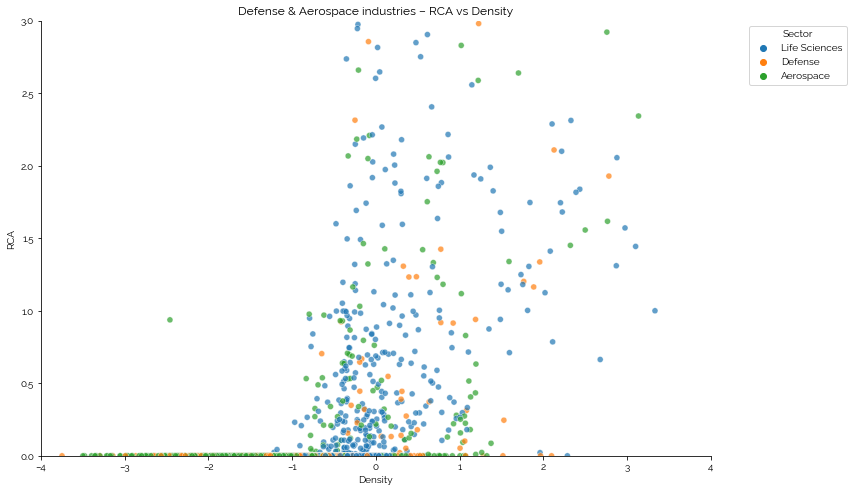

In [96]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=df_sector, x="density", y="rca", hue="Strategic Sector", alpha=0.7)
plt.xlabel("Density")
plt.ylabel("RCA")
plt.title("Defense & Aerospace industries – RCA vs Density")
plt.legend(title="Sector", bbox_to_anchor=(1.05, 1), loc="upper left")
ylim = plt.ylim(0,3)
xlim = plt.xlim(-4,4)
sns.despine()
plt.show()

<ipython-input-42-1cec26c6296e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sector["rca_specialized"] = df_sector["rca"] >= 1


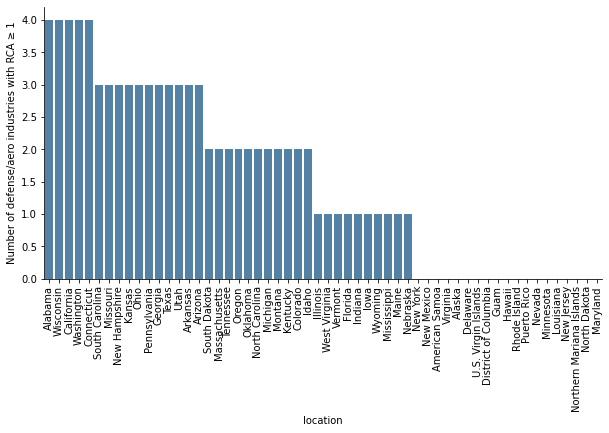

In [42]:
df_sector["rca_specialized"] = df_sector["rca"] >= 1
state_specialization = (df_sector.groupby("location", as_index=False).agg(n_specialized=("rca_specialized", "sum"),avg_density=("density", "mean"),
        avg_pci=("pci", "mean")))

plt.figure(figsize=(10,5))
state_specialization = state_specialization.sort_values("n_specialized", ascending=False)
sns.barplot(data=state_specialization,x="location", y="n_specialized", color ='steelblue')
plt.xticks(rotation=90)
plt.ylabel("Number of defense/aero industries with RCA ≥ 1")
sns.despine()
plt.show()

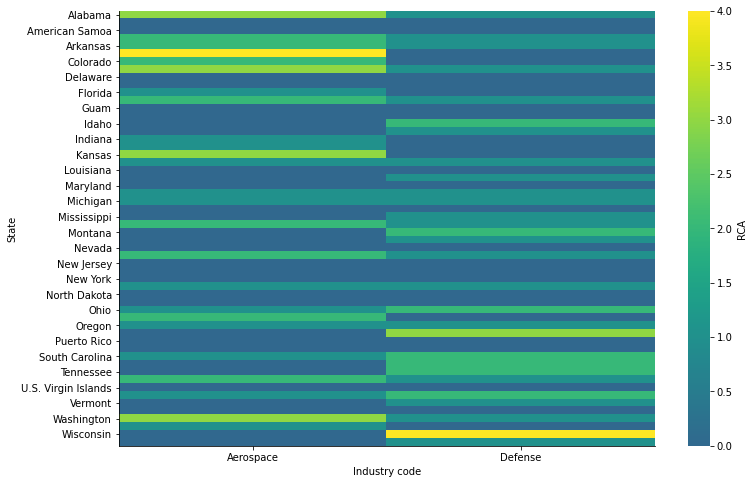

In [51]:
heat = df_sector.pivot_table( index="location",  columns="Strategic Sector", values="rca_specialized", aggfunc="sum")
plt.figure(figsize=(12,8))
sns.heatmap(heat, cmap="viridis",center=1,cbar_kws={"label": "RCA"})
plt.xlabel("Industry code")
plt.ylabel("State")
sns.despine()
plt.show()

In [53]:
import numpy as np

In [56]:
df_sector["specialized"] = df_sector["rca"] >= 1
df_sector["opportunity_density"] = np.where(df_sector["specialized"], np.nan, df_sector["density"])

state_readiness = (df_sector.groupby("location", as_index=False).agg(
        n_specialized      = ("specialized", "sum"),             # how many defense/aero NAICS with RCA≥1
        avg_rca_def        = ("rca", "mean"),                    # average RCA over all def/aero NAICS
        avg_density_all    = ("density", "mean"),                # overall ecosystem thickness
        opp_density_mean   = ("opportunity_density", "mean"))
)
state_readiness = state_readiness.sort_values("opp_density_mean", ascending=False)
state_readiness.head(5)

<ipython-input-56-9eacd6e9c77a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sector["specialized"] = df_sector["rca"] >= 1
<ipython-input-56-9eacd6e9c77a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sector["opportunity_density"] = np.where(df_sector["specialized"], np.nan, df_sector["density"])


,location,n_specialized,avg_rca_def,avg_density_all,opp_density_mean
16,Indiana,1,0.25,0.36,0.15
34,New York,0,0.22,0.07,0.07
15,Illinois,1,0.44,0.29,0.02
46,Tennessee,2,2.62,0.43,-0.15
17,Iowa,1,0.25,-0.06,-0.27


In [59]:
cols_to_show = ["location","n_specialized", "avg_rca_def","opp_density_mean"]
state_readiness.sort_values("opp_density_mean", ascending=False)[cols_to_show].head(10)

,location,n_specialized,avg_rca_def,opp_density_mean
16,Indiana,1,0.25,0.15
34,New York,0,0.22,0.07
15,Illinois,1,0.44,0.02
46,Tennessee,2,2.62,-0.15
17,Iowa,1,0.25,-0.27
19,Kentucky,2,0.42,-0.29
47,Texas,3,0.84,-0.29
0,Alabama,4,1.69,-0.30
25,Minnesota,0,0.13,-0.34
23,Massachusetts,2,0.58,-0.37


In [60]:
df_sector.loc[df_sector["location"] == "Ohio"].sort_values("opportunity_density", ascending=False)[["NAICS_2022", "NAICS_Description", "Strategic Sector", "rca", "density", "opportunity_density"]].head(10)

,NAICS_2022,NAICS_Description,Strategic Sector,rca,density,opportunity_density
35407,332992,Small Arms Ammunition Manufacturing,Defense,0.75,1.36,1.36
35500,336411,Aircraft Manufacturing,Aerospace,0.02,0.78,0.78
35502,336413,Other Aircraft Parts and Auxiliary Equipment M...,Aerospace,0.67,0.75,0.75
35409,332994,"Small Arms, Ordnance, and Ordnance Accessories...",Defense,0.29,0.58,0.58
35505,336419,Other Guided Missile and Space Vehicle Parts a...,Aerospace,0.00,-1.54,-1.54
35503,336414,Guided Missile and Space Vehicle Manufacturing,Aerospace,0.00,-2.21,-2.21
35504,336415,Guided Missile and Space Vehicle Propulsion Un...,Aerospace,0.00,-2.88,-2.88
35408,332993,Ammunition (except Small Arms) Manufacturing,Defense,1.68,4.04,NaN
35501,336412,Aircraft Engine and Engine Parts Manufacturing,Aerospace,4.29,2.54,NaN
35510,336992,"Military Armored Vehicle, Tank, and Tank Compo...",Defense,2.70,4.22,NaN
